In [92]:
!pip install spacy -q
!python -m spacy download en_core_web_sm -q
!pip install wordcloud -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 104.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [93]:
import pandas as pd
import re
import spacy
nlp=spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

In [94]:
df=pd.read_csv("/content/chatgpt_style_reviews_dataset.xlsx - Sheet1.csv")
df.head()

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-09-06,Claim who accept.,Every quite sense including six lot have never...,4,morrowthomas,30,22,Flipkart,ar,Nepal,3.8.4,No
1,3/7/2025,Growth pretty wish.,Ask develop bag also his worker pass. Expert w...,4,sheakimberly,120,22,Flipkart,ar,Guinea,5.2.6,Yes
2,########,What then spend offer reason whom none.,If customer address region try near risk next ...,5,katherineali,130,21,Flipkart,es,Kuwait,3.6.5,No
3,########,Say dog drug enter director strong student.,To television loss election him small detail r...,1,eric11,72,26,Amazon,pt,Uruguay,5.7.2,No
4,########,Purpose here beyond.,Pass share must amount lot per manage world to...,5,chloe42,123,27,Amazon,zh,Mayotte,5.8.6,No


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               250 non-null    object
 1   title              250 non-null    object
 2   review             250 non-null    object
 3   rating             250 non-null    int64 
 4   username           250 non-null    object
 5   helpful_votes      250 non-null    int64 
 6   review_length      250 non-null    int64 
 7   platform           250 non-null    object
 8   language           250 non-null    object
 9   location           250 non-null    object
 10  version            250 non-null    object
 11  verified_purchase  250 non-null    object
dtypes: int64(3), object(9)
memory usage: 23.6+ KB


In [96]:
#create separate column for sentiment target variable

def sentiment_col(rating):
  if rating<=2:
    return "Negative"
  elif rating==3:
    return "Neutral"
  else:
    return "Positive"

df['sentiment'] = df['rating'].apply(sentiment_col)

df['sentiment'].value_counts()

,count
sentiment,
Negative,97
Positive,96
Neutral,57


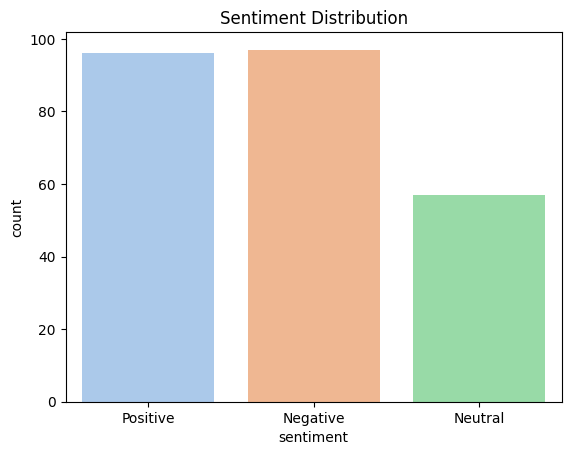

In [97]:
sns.countplot(data=df, x='sentiment', palette='pastel')
plt.title('Sentiment Distribution')
plt.show()

In [98]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # for removing special characters

    doc = nlp(text)

    # for removing istop(eg:is,the,and) and punctuation and lemmatization(shortening of words)

    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop and not token.is_punct
    ]

    return " ".join(tokens)


In [99]:
df["clean_review"] = df["review"].apply(clean_text)

df[["review", "clean_review"]].head()


,review,clean_review
0,Every quite sense including six lot have never...,sense include lot effect fill general relation...
1,Ask develop bag also his worker pass. Expert w...,ask develop bag worker pass expert white arm s...
2,If customer address region try near risk next ...,customer address region try near risk girl spr...
3,To television loss election him small detail r...,television loss election small detail red son ...
4,Pass share must amount lot per manage world to...,pass share lot manage world worker exactly dev...


In [100]:
df['sentiment'] = df['sentiment'].map({
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
})


In [101]:
df['sentiment'].value_counts()

,count
sentiment,
0,97
2,96
1,57


In [102]:
cleaned_df = df[[
        "date",
        "review",
        "clean_review",
        "rating",
        "sentiment",
        "platform",
        "location",
        "version",
        "verified_purchase",
        "helpful_votes"]
]
cleaned_df.to_csv("cleaned_reviews.csv", index=False)


In [103]:

x = df["clean_review"]
y = df["sentiment"]


x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

print("Training samples:", x_train.shape[0])
print("Testing samples:", x_test.shape[0])


Training samples: 200
Testing samples: 50


In [104]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000,random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200,random_state=42),
}


In [105]:
pipelines = {}

for name, model in models.items():
    pipelines[name] = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ("smote", SMOTE(random_state=42)),
        ("classifier", model)
    ])


In [106]:
results = []

for name, pipeline in pipelines.items():
    pipeline.fit(x_train, y_train)

    y_pred = pipeline.predict(x_test)
    y_prob = pipeline.predict_proba(x_test)

    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test,y_prob,multi_class="ovr",average="macro")
    report = classification_report(y_test, y_pred, output_dict=True)
    macro_f1 = report["macro avg"]["f1-score"]

    results.append({
        "Model": name,
        "Accuracy": acc,
        "ROC_AUC": roc_auc,
        "F1 Score": macro_f1,
        "Pipeline": pipeline,
        "Report": report
    })



In [107]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

results_df

,Model,Accuracy,ROC_AUC,F1 Score,Pipeline,Report
0,Logistic Regression,0.48,0.513441,0.404865,"(TfidfVectorizer(max_features=5000, ngram_rang...","{'0': {'precision': 0.4444444444444444, 'recal..."
1,Naive Bayes,0.44,0.506555,0.386020,"(TfidfVectorizer(max_features=5000, ngram_rang...","{'0': {'precision': 0.5238095238095238, 'recal..."
2,AdaBoost,0.34,0.500236,0.295908,"(TfidfVectorizer(max_features=5000, ngram_rang...","{'0': {'precision': 0.37037037037037035, 'reca..."
3,Random Forest,0.38,0.572133,0.281169,"(TfidfVectorizer(max_features=5000, ngram_rang...","{'0': {'precision': 0.38235294117647056, 'reca..."


In [108]:
best_model_name = results_df.iloc[0]["Model"]
best_model_name


'Logistic Regression'

In [109]:
best_pipeline = pipelines[best_model_name]
y_best_pred = best_pipeline.predict(x_test)

cm_best = confusion_matrix(y_test, y_best_pred)
cm_best

array([[12,  0,  7],
       [ 8,  1,  3],
       [ 7,  1, 11]])

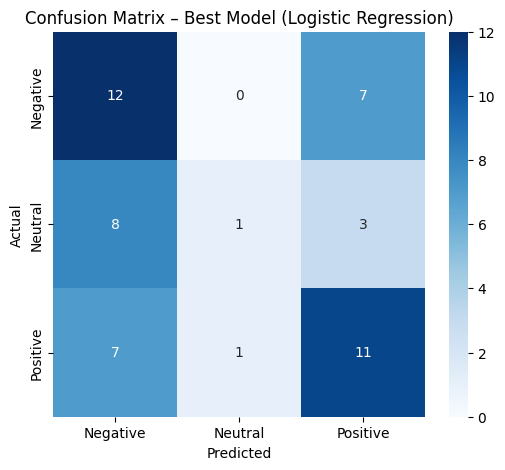

In [110]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_best,annot=True,fmt="d",cmap="Blues",
    xticklabels=["Negative", "Neutral", "Positive"],
    yticklabels=["Negative", "Neutral", "Positive"])

plt.title(f"Confusion Matrix – Best Model ({best_model_name})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [111]:
from joblib import dump
dump(best_pipeline, "best_sentiment_model.joblib")

['best_sentiment_model.joblib']

In [112]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [113]:
tokenizer.word_index

{'fact': 1,
 'short': 2,
 'picture': 3,
 'include': 4,
 'good': 5,
 'beat': 6,
 'wife': 7,
 'south': 8,
 'case': 9,
 'series': 10,
 'special': 11,
 'produce': 12,
 'total': 13,
 'mission': 14,
 'decide': 15,
 'major': 16,
 'huge': 17,
 'machine': 18,
 'truth': 19,
 'event': 20,
 'easy': 21,
 'artist': 22,
 'guess': 23,
 'goal': 24,
 'think': 25,
 'red': 26,
 'chance': 27,
 'loss': 28,
 'eat': 29,
 'leave': 30,
 'lot': 31,
 'run': 32,
 'manager': 33,
 'mention': 34,
 'question': 35,
 'develop': 36,
 'outside': 37,
 'mrs': 38,
 'woman': 39,
 'article': 40,
 'consider': 41,
 'practice': 42,
 'interest': 43,
 'computer': 44,
 'summer': 45,
 'population': 46,
 'wide': 47,
 'grow': 48,
 'personal': 49,
 'process': 50,
 'mind': 51,
 'western': 52,
 'concern': 53,
 'feel': 54,
 'gun': 55,
 'card': 56,
 'body': 57,
 'argue': 58,
 'figure': 59,
 'involve': 60,
 'account': 61,
 'edge': 62,
 'live': 63,
 'especially': 64,
 'medical': 65,
 'buy': 66,
 'center': 67,
 'pattern': 68,
 'focus': 69,
 'd

In [114]:
total_words = len(tokenizer.word_index)

total_words

757

In [115]:
max_len = 100

x_train_pad = pad_sequences(x_train_seq,maxlen=max_len,padding="post",truncating="post")

x_test_pad = pad_sequences(x_test_seq,maxlen=max_len,padding="post",truncating="post")


In [116]:
# Convert labels to categorical (using one-hot)
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)


In [117]:
model = Sequential([
    Embedding(total_words + 1, 128, input_length=max_len),
    LSTM(150,recurrent_dropout=0.1),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [118]:
lstm_model = model.fit(x_train_pad,y_train_cat,epochs=10,batch_size=32,validation_split=0.2)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 799ms/step - accuracy: 0.3569 - loss: 1.0933 - val_accuracy: 0.2000 - val_loss: 1.1184
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - accuracy: 0.3746 - loss: 1.0805 - val_accuracy: 0.2000 - val_loss: 1.1654
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step - accuracy: 0.4944 - loss: 1.0757 - val_accuracy: 0.2000 - val_loss: 1.1446
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - accuracy: 0.4336 - loss: 1.0514 - val_accuracy: 0.2000 - val_loss: 1.1115
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.4796 - loss: 1.0594 - val_accuracy: 0.2000 - val_loss: 1.1134
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.4314 - loss: 1.0736 - val_accuracy: 0.2000 - val_loss: 1.1165
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.4410 - loss: 1.0669 - val_accuracy: 0.2000 - val_loss: 1.1296
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.4102 - loss: 1.0685 - val_accuracy: 0.2000 - val_loss:

In [119]:
loss, accuracy = model.evaluate(x_test_pad, y_test_cat)
print("LSTM Test Accuracy:", accuracy)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3992 - loss: 1.0662
LSTM Test Accuracy: 0.3799999952316284


**EDA Report With Visualisations**

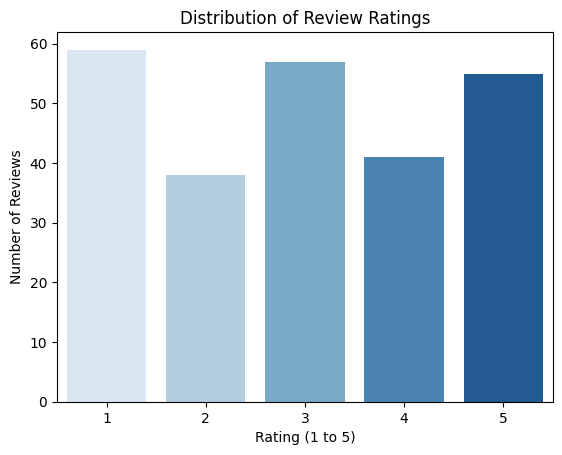

In [120]:
# 1. What is the distribution of review ratings?

sns.countplot(x="rating", data=df, palette="Blues")
plt.title("Distribution of Review Ratings")
plt.xlabel("Rating (1 to 5)")
plt.ylabel("Number of Reviews")
plt.show()

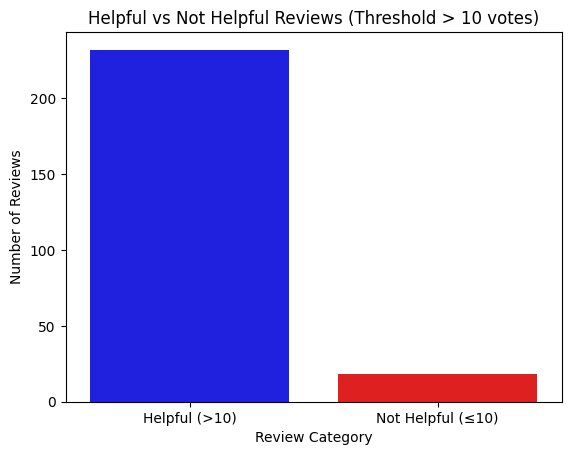

In [121]:
# 2. How many reviews were marked as helpful (above a certain threshold)?

threshold = 10

df["helpful_category"] = df["helpful_votes"].apply(lambda x: "Helpful (>10)" if x > threshold else "Not Helpful (≤10)")

sns.countplot(x="helpful_category",data=df,palette=["blue", "red"])

plt.title("Helpful vs Not Helpful Reviews (Threshold > 10 votes)")
plt.xlabel("Review Category")
plt.ylabel("Number of Reviews")
plt.show()


In [122]:
df["helpful_category"].value_counts()

,count
helpful_category,
Helpful (>10),232
Not Helpful (≤10),18


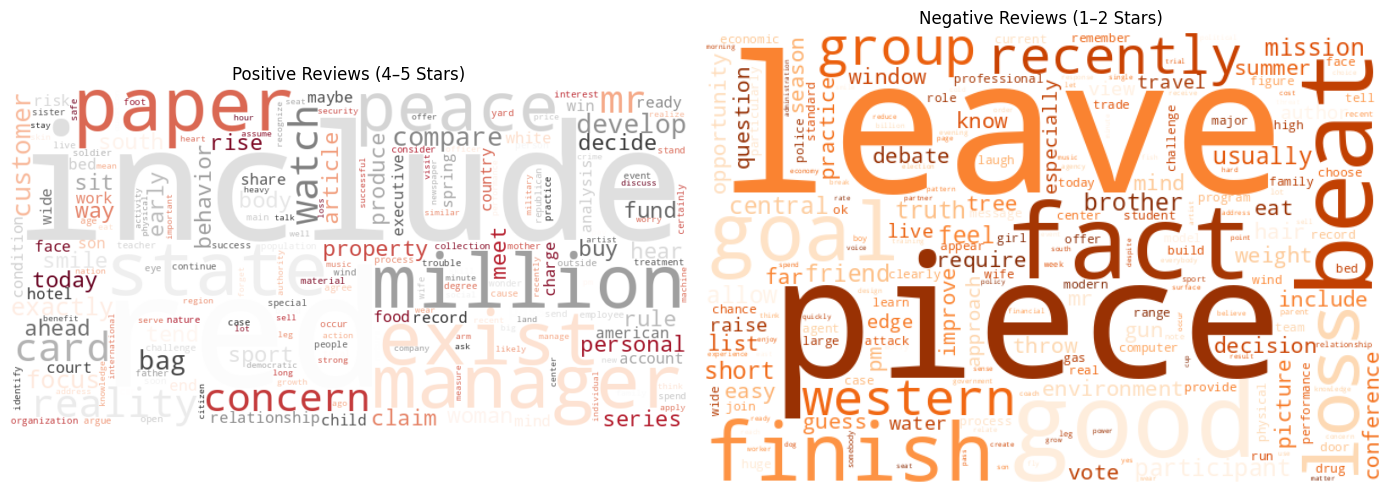

In [123]:
# 3. What are the most common keywords in positive vs. negative reviews?

positive_reviews = df[df["rating"] >= 4]["clean_review"]
negative_reviews = df[df["rating"] <= 2]["clean_review"]

positive_text = " ".join(positive_reviews)
negative_text = " ".join(negative_reviews)

positive_wc = WordCloud(width=800,height=400,background_color="white",colormap="RdGy").generate(positive_text)
negative_wc = WordCloud(width=600,height=400,background_color="white",colormap="Oranges").generate(negative_text)

plt.figure(figsize=(14, 6))

# Positive reviews word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews (4–5 Stars)")

# Negative reviews word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews (1–2 Stars)")

plt.tight_layout()
plt.show()



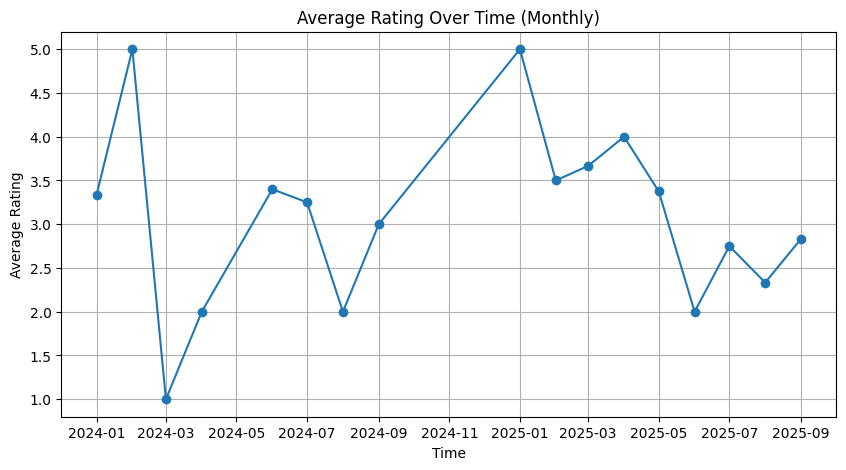

In [124]:
# 4. How has the average rating changed over time?

df["date"] = pd.to_datetime(df["date"], format="mixed", dayfirst=True, errors="coerce")

df["year_month"] = df["date"].dt.to_period("M")

monthly_avg = df.groupby("year_month")["rating"].mean()

monthly_avg.index = monthly_avg.index.to_timestamp()

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg.index, monthly_avg.values, marker="o")

plt.title("Average Rating Over Time (Monthly)")
plt.xlabel("Time")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()


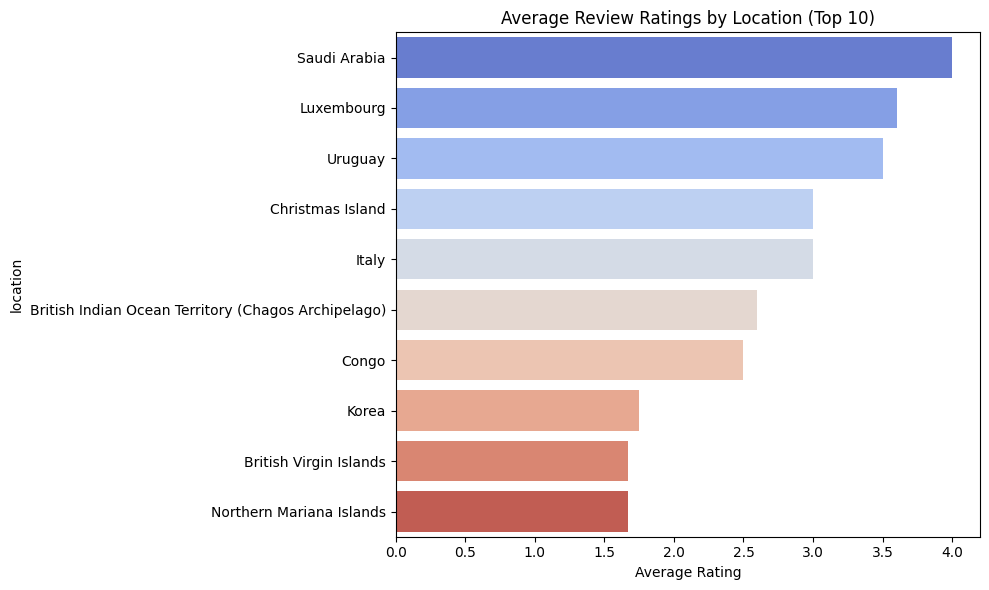

In [125]:
# 5. How do ratings vary by user location?

top_countries = df['location'].value_counts().nlargest(10).index
filtered_df = df[df['location'].isin(top_countries)]

avg_rating_by_location = filtered_df.groupby('location')['rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_rating_by_location.values, y=avg_rating_by_location.index, palette="coolwarm")
plt.xlabel('Average Rating')
plt.title('Average Review Ratings by Location (Top 10)')
plt.tight_layout()
plt.show()

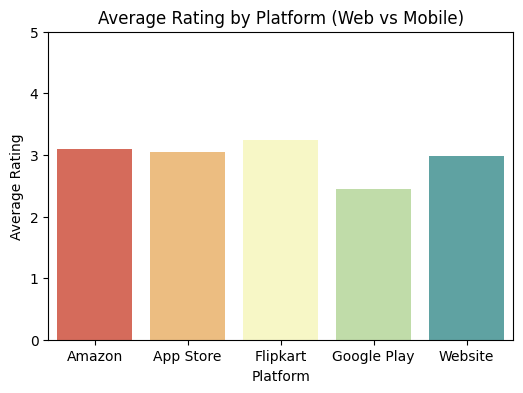

In [126]:
# 6. Which platform (Web vs Mobile) gets better reviews?

platform_avg = df.groupby("platform")["rating"].mean().reset_index()

plt.figure(figsize=(6, 4))

sns.barplot(data=platform_avg,x="platform",y="rating",palette="Spectral")

plt.title("Average Rating by Platform (Web vs Mobile)")
plt.xlabel("Platform")
plt.ylabel("Average Rating")
plt.ylim(0, 5)
plt.show()



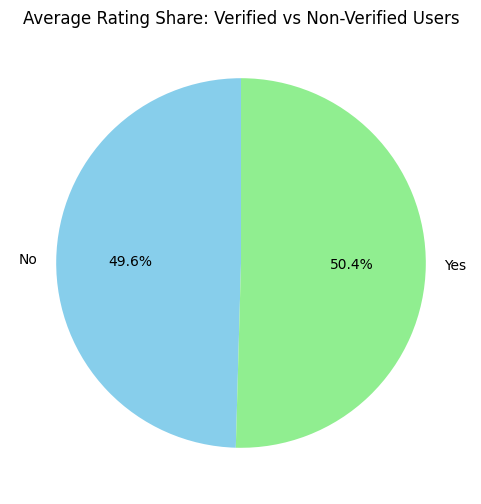

In [127]:
#  7. Are verified users more satisfied than non-verified ones?

verified_avg = (df.groupby("verified_purchase")["rating"].mean().reset_index())

plt.figure(figsize=(6, 6))
plt.pie(verified_avg["rating"],labels=verified_avg["verified_purchase"],autopct="%1.1f%%",startangle=90,colors=["skyblue", "lightgreen"])

plt.title("Average Rating Share: Verified vs Non-Verified Users")
plt.show()

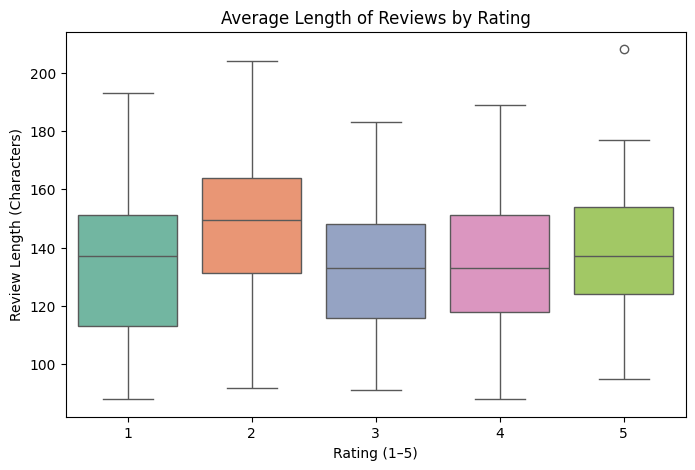

In [128]:
# 8. What’s the average length of reviews per rating category?

df["review_length"] = df["review"].astype(str).apply(len)

plt.figure(figsize=(8, 5))

sns.boxplot(data=df,x="rating",y="review_length",palette="Set2")

plt.title("Average Length of Reviews by Rating")
plt.xlabel("Rating (1–5)")
plt.ylabel("Review Length (Characters)")
plt.show()

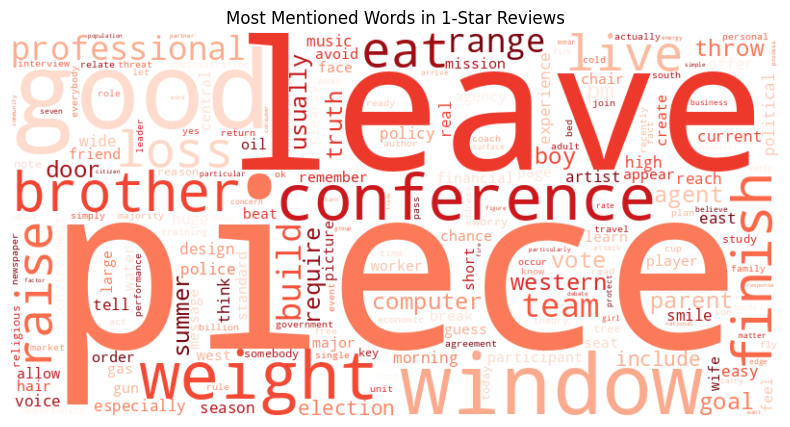

In [129]:
# 9. What are the most mentioned words in 1-star reviews?

one_star_reviews = df[df["rating"] == 1]["clean_review"]
one_star_text = " ".join(one_star_reviews)

one_star_wc = WordCloud(width=800,height=400,background_color="white",colormap="Reds").generate(one_star_text)

plt.figure(figsize=(10, 5))
plt.imshow(one_star_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Mentioned Words in 1-Star Reviews")
plt.show()

In [130]:
df['version'].value_counts()

,count
version,
5.9.6,3
1.4.7,3
4.7.3,3
3.0.6,3
2.1.7,3
...,...
2.3.8,1
1.9.3,1
2.3.4,1


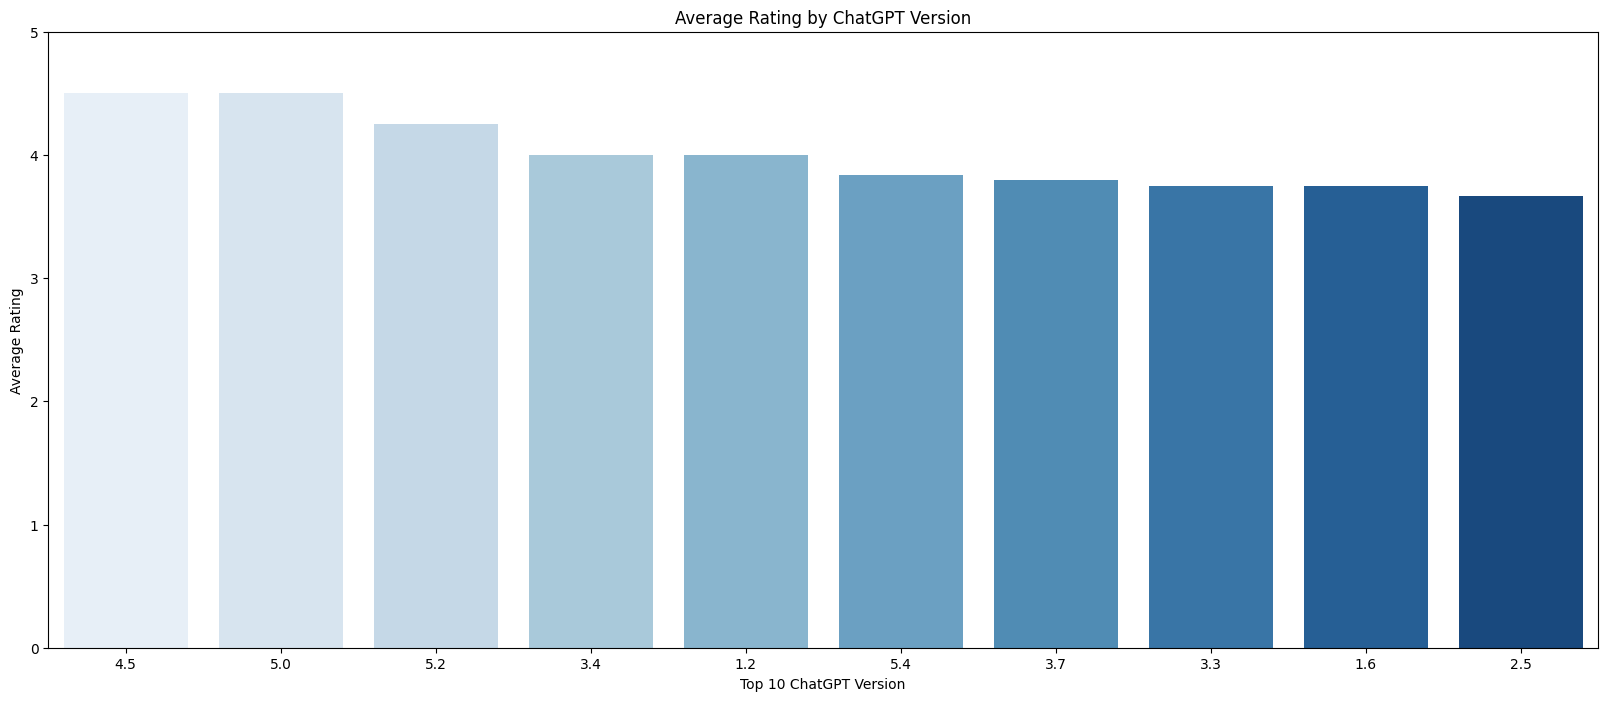

In [131]:
# 10. What ChatGPT version received the highest average rating?

df["major_version"] = df["version"].astype(str).str.extract(r"(\d+\.\d+)")

version_avg = (df.groupby("major_version")["rating"].mean().reset_index().sort_values(by="rating", ascending=False))
version_avg = version_avg.head(10)

plt.figure(figsize=(20, 8))

sns.barplot(data=version_avg,x="major_version",y="rating",palette="Blues")

plt.title("Average Rating by ChatGPT Version")
plt.xlabel("Top 10 ChatGPT Version")
plt.ylabel("Average Rating")
plt.ylim(0, 5)
plt.show()
